In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data

In [ ]:
data = pd.read_csv("data5.csv", sep=';', header=None)


In [ ]:


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1001 non-null   object
 1   1       1001 non-null   object
 2   2       1001 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [ ]:
data.head()

,0,1,2
0,date,Y,X
1,2023-01-01,0.69,yes
2,2023-01-02,0.1,no
3,2023-01-03,0.71,yes
4,2023-01-04,0.76,no


In [ ]:
# Use the first row as headers and then drop the first row
new_header = data.iloc[0]
data = data[1:].copy()
data.columns = new_header

data['date'] = pd.to_datetime(data['date']) # date
data['Y'] = data['Y'].astype(float)
# Convert the 'X' column to binary (0 and 1) while keeping it as an object type
# Assuming 'yes' maps to 1 and 'no' maps to 0
data['X'] = data['X'].map({'yes': 1, 'no': 0})



In [ ]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 1 to 1000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1000 non-null   datetime64[ns]
 1   Y       1000 non-null   float64       
 2   X       1000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 23.6 KB


In [ ]:
data.head()

,date,Y,X
1,2023-01-01,0.69,1
2,2023-01-02,0.10,0
3,2023-01-03,0.71,1
4,2023-01-04,0.76,0
5,2023-01-05,0.75,0


# Plot Data

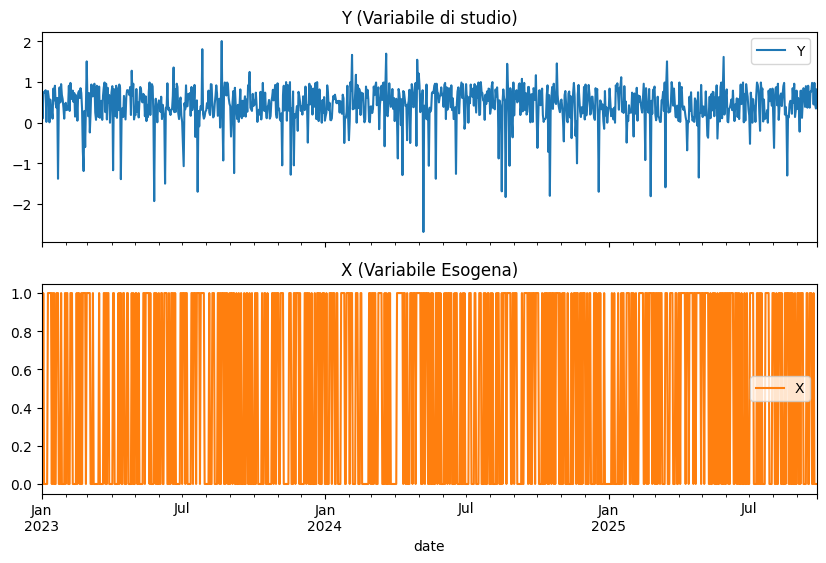

In [ ]:

# Imposta la colonna 'date' come indice del DataFrame
data_indexed = data.set_index('date')

# Plotting delle serie temporali
data_indexed.plot(subplots=True, figsize=(10, 6), title=['Y (Variabile di studio)', 'X (Variabile Esogena)'])
plt.show()

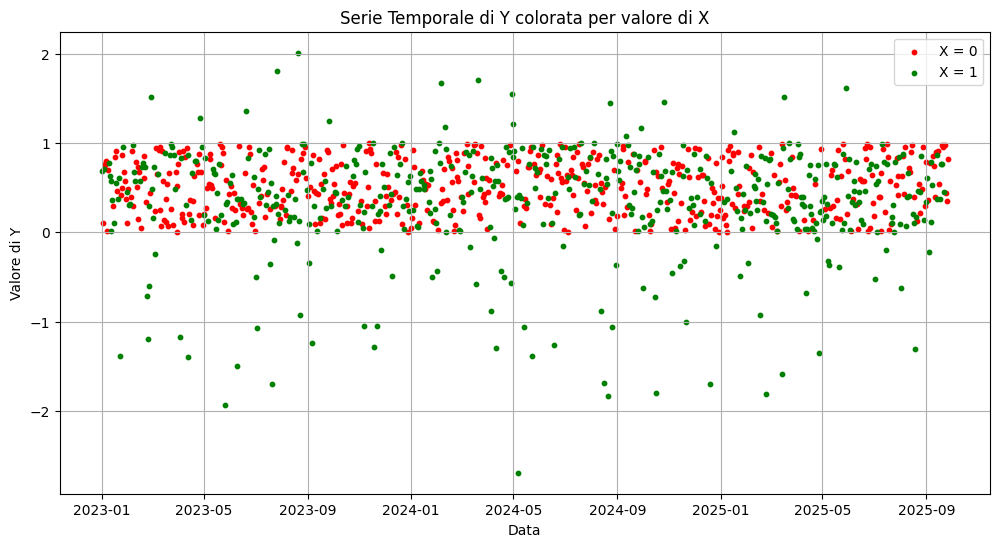

In [ ]:
import matplotlib.pyplot as plt

# Separate the data based on the value of 'X'
y_when_x_is_0 = data_indexed[data_indexed['X'] == 0]['Y']
y_when_x_is_1 = data_indexed[data_indexed['X'] == 1]['Y']

# Create the plot
plt.figure(figsize=(12, 6))

# Plot 'Y' when 'X' is 0 (red)
plt.scatter(y_when_x_is_0.index, y_when_x_is_0, color='red', label='X = 0', s=10)

# Plot 'Y' when 'X' is 1 (green)
plt.scatter(y_when_x_is_1.index, y_when_x_is_1, color='green', label='X = 1', s=10)

# Add titles and labels
plt.title('Serie Temporale di Y colorata per valore di X')
plt.xlabel('Data')
plt.ylabel('Valore di Y')
plt.legend()
plt.grid(True)
plt.show()

# Stazionarietà

In [ ]:
# Esegui il test Augmented Dickey-Fuller sulla colonna 'Y'
result_adf = adfuller(data_indexed['Y'])

# Stampa i risultati ADF
print('Risultati Test Augmented Dickey-Fuller (ADF):')
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpreta il risultato ADF
if result_adf[1] <= 0.05:
    print("La serie temporale 'Y' è probabilmente stazionaria (rifiuto l'ipotesi nulla).")
else:
    print("La serie temporale 'Y' è probabilmente non stazionaria (non posso rifiutare l'ipotesi nulla).")

print("-" * 30) # Separatore per chiarezza

# Esegui il test KPSS sulla colonna 'Y'
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(data_indexed['Y'], regression='c')

# Stampa i risultati KPSS
print('Risultati Test Kwiatkowski-Phillips-Schmidt-Shin (KPSS):')
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

# Interpreta il risultato KPSS
if result_kpss[1] > 0.05:
    print("La serie temporale 'Y' è probabilmente stazionaria (non posso rifiutare l'ipotesi nulla di stazionarietà).")
else:
    print("La serie temporale 'Y' è probabilmente non stazionaria (rifiuto l'ipotesi nulla di stazionarietà).")

Risultati Test Augmented Dickey-Fuller (ADF):
ADF Statistic: -30.692581
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
La serie temporale 'Y' è probabilmente stazionaria (rifiuto l'ipotesi nulla).
------------------------------
Risultati Test Kwiatkowski-Phillips-Schmidt-Shin (KPSS):
KPSS Statistic: 0.075403
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
La serie temporale 'Y' è probabilmente stazionaria (non posso rifiutare l'ipotesi nulla di stazionarietà).


/tmp/ipython-input-991280310.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(data_indexed['Y'], regression='c')


# ACF e PACF

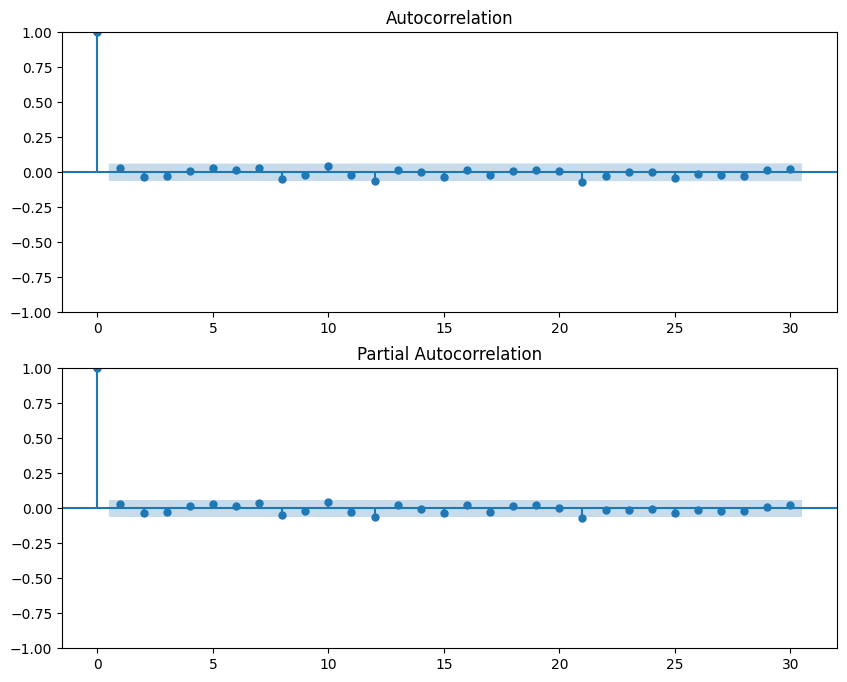

In [ ]:


# Plot ACF and PACF for the 'Y' series
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data_indexed['Y'], ax=axes[0])
plot_pacf(data_indexed['Y'], ax=axes[1])
plt.show()

# Test di Ljung-Box

In [ ]:


# Esegui il test di Ljung-Box sulla serie 'Y'
# lags=[10] esegue il test sui primi 10 ritardi
ljung_box_result = acorr_ljungbox(data_indexed['Y'], lags=[10], return_df=True)

# Stampa i risultati
print("Risultati Test di Ljung-Box:")
print(ljung_box_result)

# Interpreta il risultato (basato sul p-value per il lag specificato)
# Se il p-value è > 0.05, non possiamo rifiutare l'ipotesi nulla che le autocorrelazioni siano zero (rumore bianco)
if ljung_box_result['lb_pvalue'].iloc[0] > 0.05:
    print("\nLa serie temporale 'Y' si comporta probabilmente come rumore bianco (non possiamo rifiutare l'ipotesi nulla).")
else:
    print("\nLa serie temporale 'Y' probabilmente non è rumore bianco (rifiutiamo l'ipotesi nulla).")

Risultati Test di Ljung-Box:
      lb_stat  lb_pvalue
10  10.536132   0.394779

La serie temporale 'Y' si comporta probabilmente come rumore bianco (non possiamo rifiutare l'ipotesi nulla).


il p-value per 'X' è 0.000, che è inferiore a 0.05. Questo indica che la variabile esogena 'X' ha un impatto statisticamente significativo sulla variabile 'Y'. Il coefficiente coef per 'X' (-0.1630) ti dice la direzione e l'entità di questo impatto: in media, un cambiamento di una unità in 'X' è associato a una diminuzione di 0.1630 unità in 'Y', tenendo conto dell'intercetta.

# Model

Dipendenza di Y da X statisticamente significativa

In [ ]:


# Define the dependent variable (Y) and the independent variable (X)
Y = data_indexed['Y']
X = data_indexed['X']

# Add a constant to the independent variable for the intercept
X = sm.add_constant(X)

# Create and fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     29.24
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           8.01e-08
Time:                        13:34:04   Log-Likelihood:                -676.20
No. Observations:                1000   AIC:                             1356.
Df Residuals:                     998   BIC:                             1366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5099      0.021     24.295      0.0

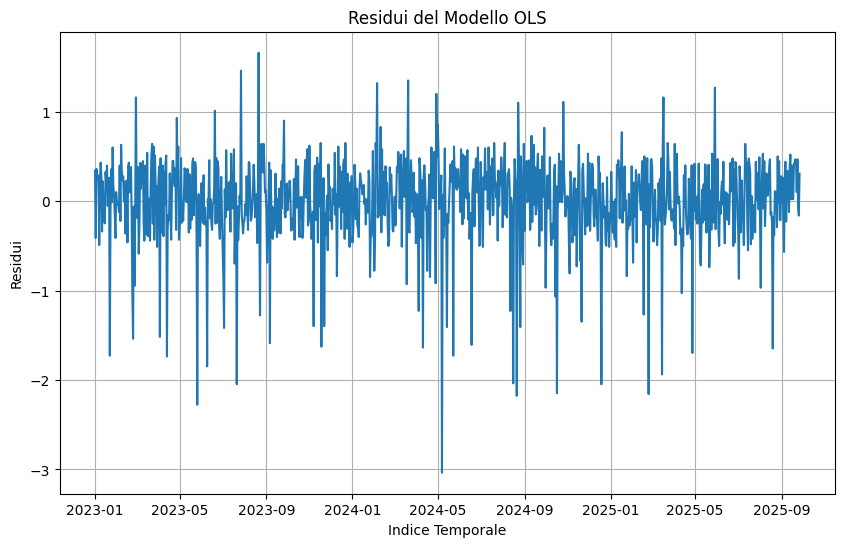

<Figure size 800x600 with 0 Axes>

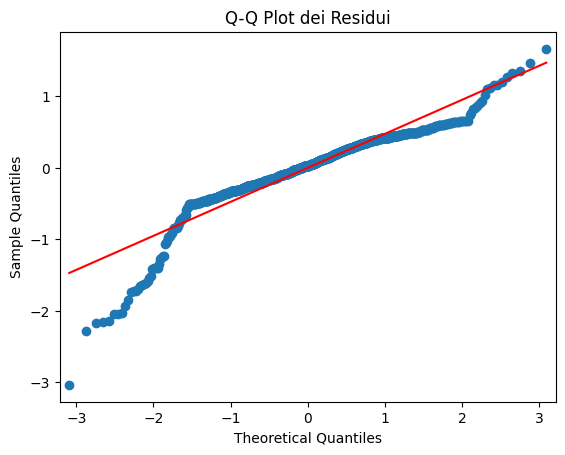

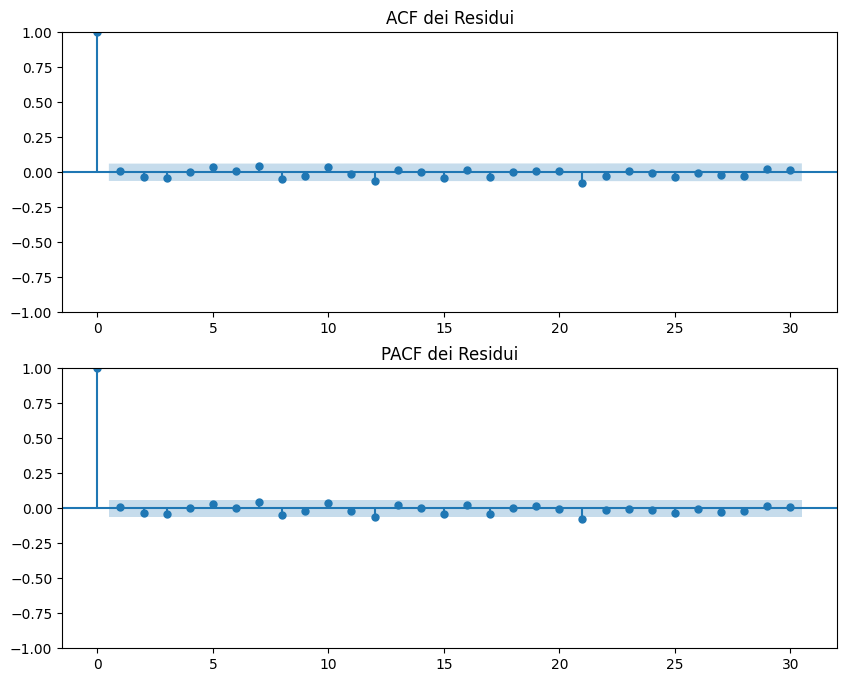

In [ ]:
# Get the residuals from the OLS model
residuals = model.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residui del Modello OLS')
plt.xlabel('Indice Temporale')
plt.ylabel('Residui')
plt.grid(True)
plt.show()

# You can also check for normality of residuals (e.g., using a histogram or a Q-Q plot)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot dei Residui')
plt.show()

# And check for autocorrelation in residuals (should be close to zero for a good model)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=axes[0], title='ACF dei Residui')
plot_pacf(residuals, ax=axes[1], title='PACF dei Residui')
plt.show()

# SARIMAX(0, 0, 0) with exogenous variable X

In [ ]:


# Define the model: SARIMAX(0, 0, 0) with exogenous variable X
# order=(p, d, q) -> (0, 0, 0) for AR, differencing, and MA components
# exogenous=X -> Specifies the exogenous variable
model_sarimax = SARIMAX(data_indexed['Y'],
                        exog=data_indexed['X'],
                        order=(0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit the model
results_sarimax = model_sarimax.fit()

# Print the model summary
print(results_sarimax.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                 1000
Model:                        SARIMAX   Log Likelihood                -907.950
Date:                Mon, 13 Oct 2025   AIC                           1819.900
Time:                        13:34:05   BIC                           1829.714
Sample:                    01-01-2023   HQIC                          1823.630
                         - 09-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3462      0.032     10.654      0.000       0.283       0.410
sigma2         0.3605      0.016     23.060      0.000       0.330       0.391
Ljung-Box (L1) (Q):                   3.06   Jarque-

## Residuals

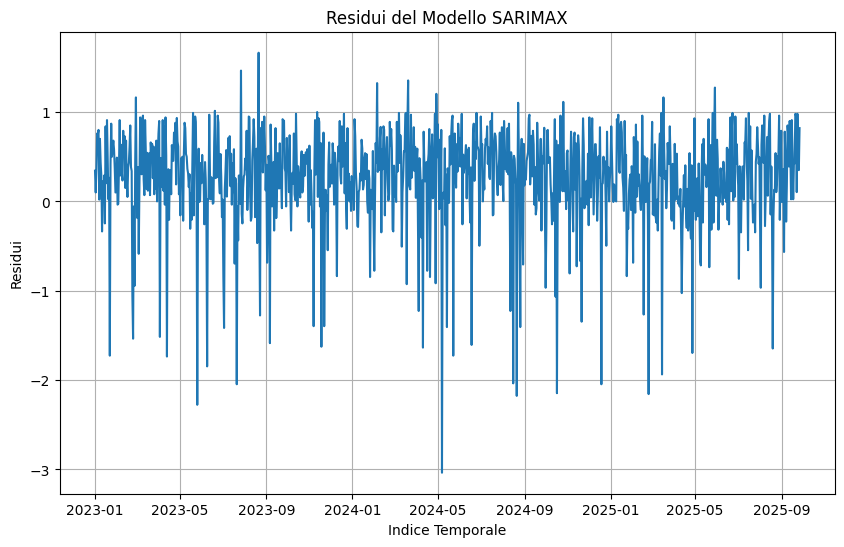

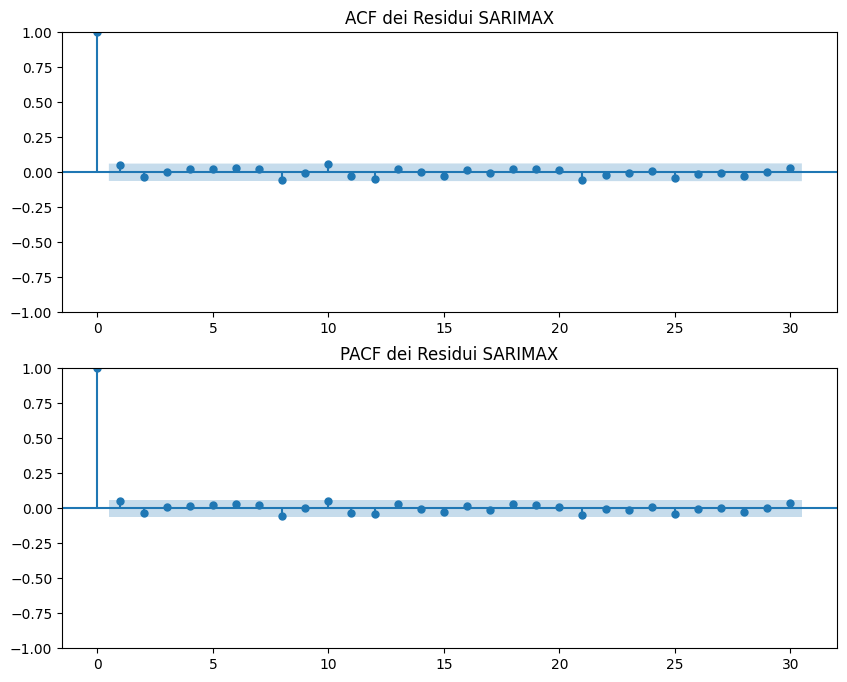

Risultati Test di Ljung-Box (Residui SARIMAX):
      lb_stat  lb_pvalue
10  12.638544   0.244589
20  18.818078   0.533678
30  26.060242   0.672053

I residui del modello SARIMAX si comportano probabilmente come rumore bianco (non possiamo rifiutare l'ipotesi nulla).


In [ ]:
# Get the residuals from the SARIMAX model
residuals_sarimax = results_sarimax.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_sarimax)
plt.title('Residui del Modello SARIMAX')
plt.xlabel('Indice Temporale')
plt.ylabel('Residui')
plt.grid(True)
plt.show()

# Plot ACF and PACF for the SARIMAX residuals
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals_sarimax, ax=axes[0], title='ACF dei Residui SARIMAX')
plot_pacf(residuals_sarimax, ax=axes[1], title='PACF dei Residui SARIMAX')
plt.show()

# Esegui il test di Ljung-Box sui residui del modello SARIMAX
# lags=[10] esegue il test sui primi 10 ritardi (o altri lags rilevanti)
ljung_box_result_sarimax = acorr_ljungbox(residuals_sarimax, lags=[10,20,30], return_df=True)

# Stampa i risultati
print("Risultati Test di Ljung-Box (Residui SARIMAX):")
print(ljung_box_result_sarimax)

# Interpreta il risultato (basato sul p-value per il lag specificato)
if ljung_box_result_sarimax['lb_pvalue'].iloc[0] > 0.05:
    print("\nI residui del modello SARIMAX si comportano probabilmente come rumore bianco (non possiamo rifiutare l'ipotesi nulla).")
else:
    print("\nI residui del modello SARIMAX probabilmente non sono rumore bianco (rifiutiamo l'ipotesi nulla).")